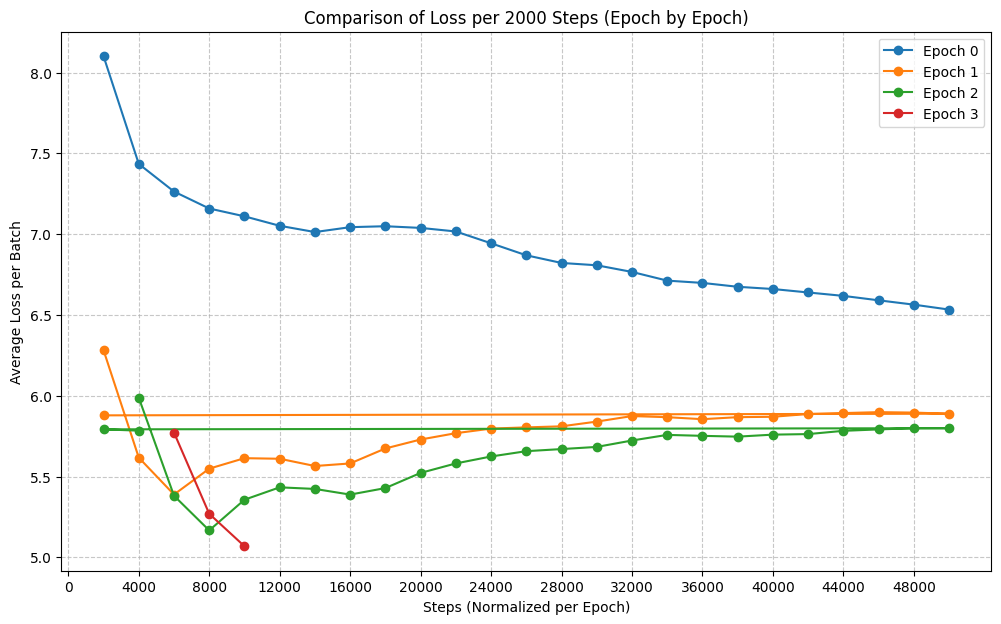

In [39]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def lr_scheduler(global_step,d_model=128,warmup_steps = 4000):
    global_step = max(global_step,1)
    lr = (d_model ** - 0.5) * min(
                                    global_step ** -0.5 ,
                                    global_step * (warmup_steps ** -1.5)
                                    )
    return lr

lr_scheduler_vec = np.vectorize(lr_scheduler)

def parse_logs_by_epoch(file_path):
    data = []
    current_step = None
    current_epoch = 0 # Default to 0

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            # 1. Detect Epoch change (e.g., "Epoch 0 ; loss 6.50...")
            epoch_match = re.search(r"Epoch (\d+)", line)
            if epoch_match:
                # We update the current_epoch for all subsequent steps
                current_epoch = int(epoch_match.group(1)) + 1 
                continue

            # 2. Capture Step
            step_match = re.search(r"step=(\d+)", line)
            if step_match:
                current_step = int(step_match.group(1))
            
            # 3. Capture the Loss (The standalone float)
            loss_match = re.match(r"^(\d+\.\d+)$", line)
            if loss_match and current_step is not None:
                loss_val = float(loss_match.group(1))
                
                # Normalize the step: 
                # To overlay lines, we need step % max_steps_per_epoch
                # Assuming 50,000 steps per epoch based on your log
                normalized_step = current_step % 50000 
                if normalized_step == 0 and current_step != 0:
                    normalized_step = 50000

                data.append({
                    "epoch": f"Epoch {current_epoch}",
                    "step": normalized_step,
                    "loss": loss_val
                })
                current_step = None 

    return pd.DataFrame(data)

# --- Process ---
df = parse_logs_by_epoch('logs.txt')

# --- Plotting ---
plt.figure(figsize=(12, 7))

# Pivot the data so each epoch is a column
# This automatically creates separate lines for each epoch
for epoch in df['epoch'].unique():
    subset = df[df['epoch'] == epoch]
    plt.plot(subset['step'], subset['loss'], marker='o', label=epoch)

plt.title('Comparison of Loss per 2000 Steps (Epoch by Epoch)')
plt.xlabel('Steps (Normalized per Epoch)')
plt.ylabel('Average Loss per Batch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the 2000 step intervals
plt.xticks(range(0, 52000, 4000))

plt.show()